In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import torchvision

np.random.seed(42)
PERMUTATIONS = [np.random.permutation(784) for _ in range(10)]

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
np.prod(1)

1

In [6]:
class ConvVectorizedLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, category_dim, stride=1, padding=0, dilation=1,
                 groups=1, padding_mode='zeros', nonneg=False, nonlin=True, expanded_input=False, pool=True, pool_size=2, pool_stride=2):
        super(ConvVectorizedLayer, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias=False, padding_mode=padding_mode)
        
        k = groups / (in_channels * np.prod(kernel_size))
        print(k)
        if expanded_input:
            k = k * category_dim
        with torch.no_grad():
            if nonneg: self.conv.weight.uniform_(0, np.sqrt(k))
            else: self.conv.weight.uniform_(-np.sqrt(k), np.sqrt(k))
        self.bias = nn.Parameter(torch.zeros(category_dim, out_channels))
        
        if pool:
            self.avgpool = nn.AvgPool2d(kernel_size=pool_size, stride=pool_stride)
        
        self.pool = pool
        self.nonneg = nonneg
        self.nonlin = nonlin
        
    def forward(self, input):
        #(batch_dim, category_dim, channels, width, height)
        input_reshaped = input.view((input.shape[0]*input.shape[1],) + input.shape[2:])
        conv_out = self.conv(input_reshaped)
        saved_shape = conv_out.shape
        conv_out = conv_out.view((input.shape[0], input.shape[1]) + conv_out.shape[1:]) #?
        conv_out = conv_out + self.bias[None, :, :, None, None]
        if self.nonlin:
            conv_out_sum = conv_out.sum(dim=1).detach()
            mask = (conv_out_sum > 0.).float()
            conv_out = conv_out * mask[:, None, :, :, :]
        if self.pool:
            conv_out = conv_out.view(saved_shape)
            conv_out = self.avgpool(conv_out)
            conv_out = conv_out.view((input.shape[0], input.shape[1]) + conv_out.shape[1:])
        return conv_out
    
    def post_step_callback(self):
        if self.nonneg:
            with torch.no_grad():
                self.conv.weight.clamp_(min=0)
                



In [44]:
conv = ConvVectorizedLayer(in_channels=10, out_channels=3, kernel_size=6,
                           category_dim=10, nonneg=True, nonlin=True, pool=True, pool_size=3, pool_stride=2)

In [12]:
def expand_input(input, category_dim):
    #input = (batch, channels, width, height)
    batch_size, in_channels = input.shape[:2]
    expanded_input = torch.zeros((batch_size, category_dim, in_channels*category_dim) + input.shape[2:])
    for i in range(category_dim):
        expanded_input[:, i, i*in_channels:(i+1)*in_channels] = input
    return expanded_input

    

In [21]:
import layers
from imp import reload
reload(layers)

<module 'layers' from '/Users/davidclark/Projects/VectorizedNets/layers.py'>

In [22]:
class VectorizedLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_part = nn.Sequential(ConvVectorizedLayer(30, 6, 5, 10, expanded_input=True, nonlin=True, nonneg=False, pool=True),
                                  ConvVectorizedLayer(6, 16, 5, 10, expanded_input=False, nonlin=True, nonneg=False, pool=True),
                                  ConvVectorizedLayer(16, 120, 5, 10, expanded_input=False, nonlin=True, nonneg=False, pool=False))
        self.fc_part = nn.Sequential(layers.VectorizedLayer(120, 84, 10, expanded_input=False, nonlin=True, nonneg=False),
                                layers.VectorizedLayer(84, 1, 10, expanded_input=False, nonlin=False, nonneg=False))
        
    def post_step_callback(self):
        for i in range(len(self.conv_part)):
            self.conv_part[i].post_step_callback()
        for i in range(len(self.fc_part)):
            self.fc_part[i].post_step_callback()
        
    def forward(self, input):
        conv_out = self.conv_part(input)
        conv_out = conv_out.view(conv_out.shape[:2] + (120,))
        fc_out = self.fc_part(conv_out)
        return fc_out
        

In [23]:
input = torch.randn(128, 10, 30, 32, 32)

model = VectorizedLeNet()

#model(input).shape

0.006666666666666667
0.03333333333333333
0.0125


In [11]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
#dataiter = iter(train_loader)
#images, labels = dataiter.next()

#images.std()

In [26]:
#model = VectorizedLeNet()
loss_fn = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch_idx in range(1000):
    print(epoch_idx)
    epoch_loss = 0.
    for batch_idx, (data, labels) in enumerate(train_loader):
        input = expand_input(data, 10)
        optimizer.zero_grad()
        out = model(input)[..., 0]
        loss = loss_fn(out, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        acc = (out.detach().argmax(dim=1) == labels).float().mean()
        print(acc)
        
    print(epoch_loss / (batch_idx + 1))


0
tensor(0.2734)
tensor(0.4297)
tensor(0.4375)
tensor(0.4375)
tensor(0.4766)
tensor(0.3984)
tensor(0.4219)
tensor(0.4688)
tensor(0.3750)
tensor(0.4297)
tensor(0.4297)
tensor(0.4531)
tensor(0.3828)
tensor(0.4688)
tensor(0.4062)
tensor(0.3438)
tensor(0.3984)
tensor(0.4375)
tensor(0.3984)
tensor(0.4141)
tensor(0.3594)
tensor(0.4531)
tensor(0.4766)
tensor(0.4531)
tensor(0.4531)
tensor(0.4219)
tensor(0.4766)
tensor(0.4141)
tensor(0.5078)
tensor(0.3516)
tensor(0.5156)
tensor(0.4141)
tensor(0.5156)
tensor(0.4609)
tensor(0.4766)
tensor(0.4375)
tensor(0.4609)
tensor(0.4688)
tensor(0.4062)
tensor(0.4141)
tensor(0.5156)
tensor(0.5156)
tensor(0.4766)
tensor(0.4219)
tensor(0.4297)
tensor(0.4453)
tensor(0.4453)
tensor(0.4297)
tensor(0.4922)
tensor(0.4297)
tensor(0.4297)
tensor(0.3984)
tensor(0.4688)
tensor(0.4375)
tensor(0.3984)
tensor(0.5234)
tensor(0.4453)
tensor(0.4531)
tensor(0.3984)
tensor(0.4609)
tensor(0.4375)
tensor(0.4609)
tensor(0.4297)
tensor(0.4141)
tensor(0.3750)
tensor(0.3594)
tensor(0

KeyboardInterrupt: 

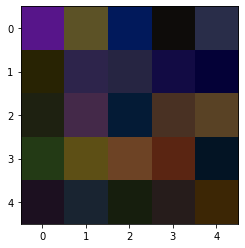

In [37]:
plt.imshow(model.conv_part[0].conv.weight.detach()[0, :3].permute(1, 2, 0).abs())

In [29]:
x = torch.randn(5, 5)
A = torch.randn(5, 5)
B = torch.randn(5, 5)

A.requires_grad = True
B.requires_grad = False

y = A.mm(B).mm(x)
l = y.sum()
l.backward()

In [31]:
B.grad